In [1]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="U1bTSJUMzADoWHTByhy0")
# project = rf.workspace("saurav").project("hard-hat-sample-gjksx")
# dataset = project.version(3).download("tfrecord")


In [2]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"

--2023-10-28 10:13:09--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  18.2MB/s    in 45s     

2023-10-28 10:13:54 (16.9 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [3]:
import tarfile

# open file
file = tarfile.open('/content/images.tar')

# extracting file
file.extractall('./Destination_FolderName')

file.close()

In [4]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer.git

Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 43 (delta 15), reused 26 (delta 6), pack-reused 0
Receiving objects: 100% (43/43), 862.11 KiB | 8.21 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [5]:
%cd /content/Image-Classification-Using-Vision-transformer

/content/Image-Classification-Using-Vision-transformer


In [6]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [7]:
#get the class name from folder
import os
d='/content/Destination_FolderName/Images/'
folders = list(filter(lambda x: os.path.isdir(os.path.join(d, x)), os.listdir(d)))

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
#class_names = ['daisy','dandelion']
class_names = folders

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 136MB/s]


In [10]:
!pip install torchinfo

In [11]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 120]            768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

# Spliting Dataset

In [12]:
!pip install split-folders

In [13]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/Destination_FolderName/Images/", output="/content/",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 20580 files [00:03, 5448.28 files/s]


In [14]:
# Setup directory paths to train and test images
train_dir = '/content/train/'
test_dir = '/content/test/'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [15]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


#And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [16]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [17]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could

In [18]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5072 | train_acc: 0.9148 | test_loss: 0.1825 | test_acc: 0.9494
Epoch: 2 | train_loss: 0.1292 | train_acc: 0.9621 | test_loss: 0.1741 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.0932 | train_acc: 0.9708 | test_loss: 0.1786 | test_acc: 0.9467
Epoch: 4 | train_loss: 0.0707 | train_acc: 0.9785 | test_loss: 0.1888 | test_acc: 0.9435
Epoch: 5 | train_loss: 0.0565 | train_acc: 0.9832 | test_loss: 0.1875 | test_acc: 0.9458
Epoch: 6 | train_loss: 0.0454 | train_acc: 0.9861 | test_loss: 0.1881 | test_acc: 0.9476
Epoch: 7 | train_loss: 0.0376 | train_acc: 0.9879 | test_loss: 0.1949 | test_acc: 0.9449
Epoch: 8 | train_loss: 0.0326 | train_acc: 0.9909 | test_loss: 0.2046 | test_acc: 0.9458
Epoch: 9 | train_loss: 0.0281 | train_acc: 0.9920 | test_loss: 0.2006 | test_acc: 0.9449
Epoch: 10 | train_loss: 0.0246 | train_acc: 0.9928 | test_loss: 0.2196 | test_acc: 0.9439


#pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).

<!-- **We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.** -->

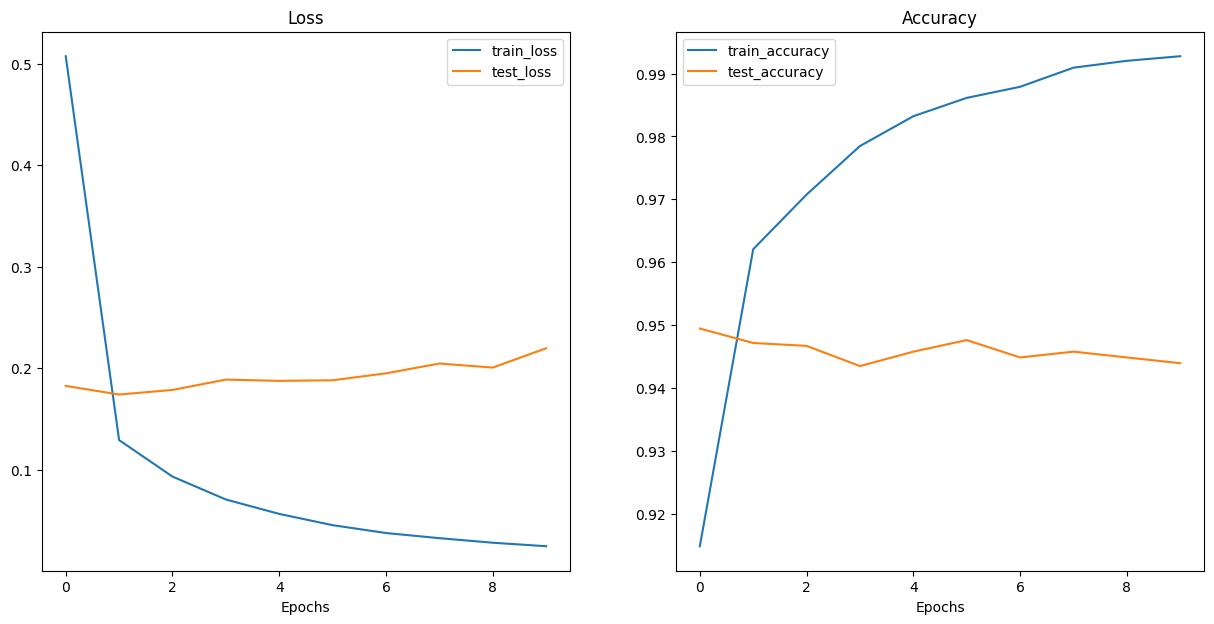

In [19]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [20]:
#Let's make Prediction:

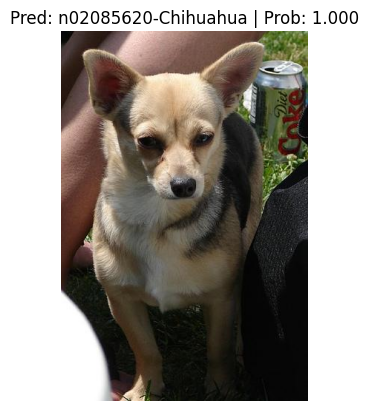

In [21]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/train/n02085620-Chihuahua/n02085620_10074.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

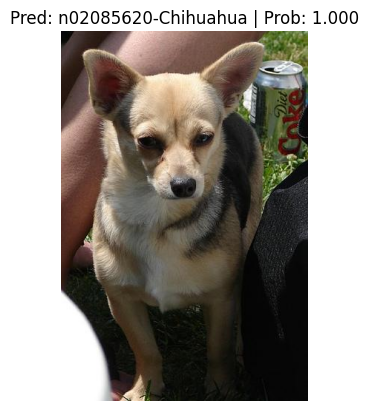

In [22]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/train/n02085620-Chihuahua/n02085620_10074.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)